In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences and pad them
max_length = 100  # Define max length for padding
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Pad the labels as well to match max_length
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels_padded, epochs=5, validation_data=(test_padded, test_labels_padded))

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/5


c:\Users\manan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.9860 - loss: 0.1030 - val_accuracy: 0.9977 - val_loss: 0.0087
Epoch 2/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9988 - val_loss: 0.0060
Epoch 3/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 0.9988 - val_loss: 0.0056
Epoch 4/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9988 - val_loss: 0.0053
Epoch 5/5
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9987 - val_loss: 0.0055
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9989 - loss: 0.0047
Test Accuracy: 99.87%


In [51]:
def predict_bad_words(sentence, tokenizer, model, max_length=100):
    # Tokenize and pad the new sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Predict with the model
    predictions = model.predict(padded_sequence)[0]  # Get predictions for each word
    
    # Retrieve the words in the sentence and interpret the predictions
    words = sentence.split()
    bad_word_predictions = []
    
    for i, word in enumerate(words):
        # If the model prediction for this word is close to 1, classify as a bad word
        if i < max_length:
            is_bad = predictions[i][0] > 0.5  # Threshold of 0.5
            bad_word_predictions.append((word, is_bad))
        else:
            break  # Stop if words exceed the max length used in the model
    
    return bad_word_predictions

# Example usage
new_sentence = "तू हमेशा दूसरों को चुतिये और गांडू बोलता है, खुद हर बात में फुद्दी की बातें करता है, मादरचोद"
bad_word_predictions = predict_bad_words(new_sentence, tokenizer, model)

# Display predictions
for word, is_bad in bad_word_predictions:
    label = "Bad Word" if is_bad else "Normal"
    print(f"{word}: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
तू: Normal
हमेशा: Normal
दूसरों: Normal
को: Normal
चुतिये: Normal
और: Normal
गांडू: Bad Word
बोलता: Normal
है,: Normal
खुद: Normal
हर: Normal
बात: Normal
में: Normal
फुद्दी: Normal
की: Normal
बातें: Normal
करता: Normal
है,: Normal
मादरचोद: Bad Word


In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)

# Convert text to sequences and pad them
max_length = max(len(seq) for seq in sequences)  
print(max_length) # Define max length for padding
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Pad the labels as well to match max_length
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

# Load pre-trained fastText Hindi embeddings
embedding_index = {}
embedding_dim = 300  # fastText embeddings are typically 300-dimensional

# Path to the fastText Hindi embedding file (e.g., "cc.hi.300.vec")
with open("cc.hi.300.vec", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Prepare the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model with pre-trained embeddings
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False  # Set to True if you want to fine-tune embeddings
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels_padded, epochs=5, validation_data=(test_padded, test_labels_padded))

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


475
Epoch 1/5


c:\Users\manan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 83/254 ━━━━━━━━━━━━━━━━━━━━ 3:59 1s/step - accuracy: 0.9866 - loss: 0.3329

KeyboardInterrupt: 

In [62]:
def preprocess_sentence(sentence):
    """
    Preprocesses a single sentence by tokenizing and padding.
    """
    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    
    # Pad the sequence to match the max_length
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    return padded_sequence

def predict_bad_words(sentence):
    """
    Predicts bad words in a new sentence.
    """
    # Preprocess the sentence
    padded_sequence = preprocess_sentence(sentence)
    
    # Get predictions from the model
    predictions = model.predict(padded_sequence)
    
    # Threshold to classify as bad word or not
    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)[0]
    
    # Print out each word with its prediction
    words = sentence.split()
    for i, word in enumerate(words[:max_length]):
        is_bad_word = "Bad Word" if predicted_labels[i] == 1 else "Normal Word"
        print(f"{word}: {is_bad_word}")

# Example sentence in Hindi containing some abusive words
new_sentence = "तू खुद को क्या समझता है, चूतिया साला? हर बार बकवास करता है और दूसरों को परेशान करता है। कमीने, तमीज से पेश आ।"



# Predict on the new sentence
predict_bad_words(new_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
तू: Normal Word
खुद: Normal Word
को: Normal Word
क्या: Normal Word
समझता: Normal Word
है,: Normal Word
चूतिया: Bad Word
साला?: Bad Word
हर: Normal Word
बार: Normal Word
बकवास: Normal Word
करता: Normal Word
है: Normal Word
और: Normal Word
दूसरों: Normal Word
को: Normal Word
परेशान: Normal Word
करता: Normal Word
है।: Normal Word
कमीने,: Bad Word
तमीज: Normal Word
से: Normal Word
पेश: Normal Word
आ।: Normal Word


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Tokenize the sentences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(sentences)

# Set max length based on longest sequence
max_length = max(len(seq) for seq in sequences)
print("Max length:", max_length)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
train_labels_padded = pad_sequences(train_labels, maxlen=max_length, padding='post', truncating='post')
test_labels_padded = pad_sequences(test_labels, maxlen=max_length, padding='post', truncating='post')

# Load pre-trained fastText Hindi embeddings
embedding_index = {}
embedding_dim = 300  # fastText embeddings are typically 300-dimensional
with open("cc.hi.300.vec", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

# Prepare the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define character-level input
char_tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
char_tokenizer.fit_on_texts(sentences)
char_vocab_size = len(char_tokenizer.word_index) + 1
char_max_length = 15  # max characters per word (you can adjust as needed)

def char_level_tokenizer(sentences, max_words, char_max_length):
    char_sequences = []
    for sentence in sentences:
        sentence_chars = []
        for word in sentence.split():
            char_sequence = [char_tokenizer.word_index.get(char, 0) for char in word]
            char_sequence = pad_sequences([char_sequence], maxlen=char_max_length, padding="post")[0]
            sentence_chars.append(char_sequence)
        
        # Pad the word-level sequences to max_words length
        sentence_chars = pad_sequences([sentence_chars], maxlen=max_words, padding="post", dtype="int32")[0]
        char_sequences.append(sentence_chars)
    
    return np.array(char_sequences)

# Apply the function with max_length and char_max_length
train_char_sequences = char_level_tokenizer(train_sentences, max_length, char_max_length)
test_char_sequences = char_level_tokenizer(test_sentences, max_length, char_max_length)


# Build the model
word_input = tf.keras.layers.Input(shape=(max_length,))
word_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False
)(word_input)

char_input = tf.keras.layers.Input(shape=(max_length, char_max_length))
char_embedding = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim=32, input_length=char_max_length)
)(char_input)
char_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))(char_embedding)
char_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(char_conv)

# Concatenate word and character embeddings
concatenated = tf.keras.layers.concatenate([word_embedding, char_pool])

# LSTM layer
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concatenated)
dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu'))(lstm)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid'))(dense)

# Define and compile the model
model = tf.keras.Model(inputs=[word_input, char_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_padded, train_char_sequences], train_labels_padded,
    epochs=5,
    validation_data=([test_padded, test_char_sequences], test_labels_padded)
)

# Evaluate the model
loss, accuracy = model.evaluate([test_padded, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Max length: 475


c:\Users\manan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
150/254 ━━━━━━━━━━━━━━━━━━━━ 13:30 8s/step - accuracy: 0.9601 - loss: 0.0978

KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('annotated_bad_words.csv')

# Preprocess the text data
def extract_labels(sentence):
    words = sentence.split()
    tokens = []
    labels = []
    
    for word in words:
        if "<bad_word>" in word:
            word = word.replace("<bad_word>", "").replace("</bad_word>", "")
            labels.append(1)  # Label '1' for bad word
        else:
            labels.append(0)  # Label '0' for normal word
        tokens.append(word)
    
    return " ".join(tokens), labels

# Apply label extraction
data['Processed Sentences'], data['Labels'] = zip(*data['Annotated Sentences'].apply(extract_labels))

# Split the data into training and test sets
sentences = data['Processed Sentences'].tolist()
labels = data['Labels'].tolist()
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Load IndicBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("ai4bharat/indic-bert")
indicbert_model = TFBertModel.from_pretrained("ai4bharat/indic-bert")

# Tokenize sentences with IndicBERT
def tokenize_sentences(sentences):
    encoding = tokenizer(sentences, padding=True, truncation=True, return_tensors="tf", max_length=128)
    return encoding["input_ids"], encoding["attention_mask"]

train_inputs, train_masks = tokenize_sentences(train_sentences)
test_inputs, test_masks = tokenize_sentences(test_sentences)

# Pad the labels to match max length
max_length = train_inputs.shape[1]
train_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(train_labels, maxlen=max_length, padding='post')
test_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(test_labels, maxlen=max_length, padding='post')

# Define character-level input (similar to your previous code)
char_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, oov_token="<OOV>")
char_tokenizer.fit_on_texts(sentences)
char_vocab_size = len(char_tokenizer.word_index) + 1
char_max_length = 15

def char_level_tokenizer(sentences, max_words, char_max_length):
    char_sequences = []
    for sentence in sentences:
        sentence_chars = []
        for word in sentence.split():
            char_sequence = [char_tokenizer.word_index.get(char, 0) for char in word]
            char_sequence = tf.keras.preprocessing.sequence.pad_sequences([char_sequence], maxlen=char_max_length, padding="post")[0]
            sentence_chars.append(char_sequence)
        sentence_chars = tf.keras.preprocessing.sequence.pad_sequences([sentence_chars], maxlen=max_words, padding="post")[0]
        char_sequences.append(sentence_chars)
    return np.array(char_sequences)

train_char_sequences = char_level_tokenizer(train_sentences, max_length, char_max_length)
test_char_sequences = char_level_tokenizer(test_sentences, max_length, char_max_length)

# Define Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# Build the model
word_input = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
char_input = tf.keras.layers.Input(shape=(max_length, char_max_length))

# IndicBERT embedding for word-level input
indicbert_embeddings = indicbert_model(word_input, attention_mask=attention_mask)[0]

# Character-level embedding
char_embedding = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Embedding(input_dim=char_vocab_size, output_dim=32, input_length=char_max_length)
)(char_input)
char_conv = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))(char_embedding)
char_pool = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(char_conv)

# Concatenate word and character embeddings
concatenated = tf.keras.layers.concatenate([indicbert_embeddings, char_pool])

# LSTM layer with Attention
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concatenated)
attention = AttentionLayer()(lstm)
output = tf.keras.layers.Dense(1, activation='sigmoid')(attention)

# Define and compile the model
model = tf.keras.Model(inputs=[word_input, attention_mask, char_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_inputs, train_masks, train_char_sequences], train_labels_padded,
    epochs=5,
    validation_data=([test_inputs, test_masks, test_char_sequences], test_labels_padded)
)

# Evaluate the model
loss, accuracy = model.evaluate([test_inputs, test_masks, test_char_sequences], test_labels_padded)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('word2vec_bad_model.h5')

# Ensure test data is in the correct format (as in your training code)
# Convert to numpy int32 arrays if needed
test_padded = np.array(test_padded, dtype=np.int32)
test_char_sequences = np.array(test_char_sequences, dtype=np.int32)
test_labels_padded = np.array(test_labels_padded, dtype=np.int32)

# Predict the output probabilities for each token in each test sequence
y_pred_proba = model.predict([test_padded, test_char_sequences])

# Threshold the probabilities to get binary predictions (e.g., threshold = 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Flatten the outputs for comparison (since outputs are token-level)
y_true = test_labels_padded.flatten()
y_pred_flat = y_pred.flatten()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_flat))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_flat))

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba.flatten())
roc_auc = roc_auc_score(y_true, y_pred_proba.flatten())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


NameError: name 'test_padded' is not defined

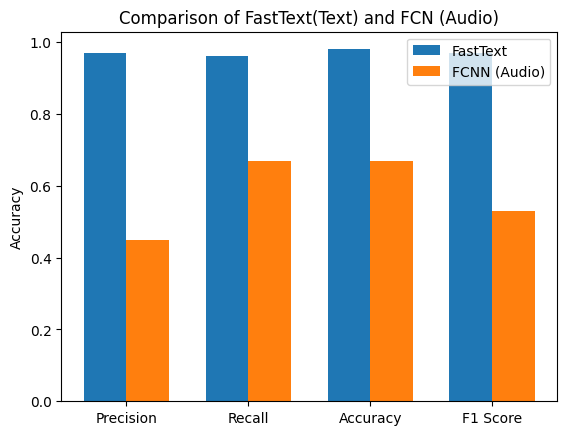

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data (adjust according to your actual data)
data = {
    'FastText': [0.97, 0.96, 0.98, 0.97],
    'FCNN (Audio)': [0.45, 0.67, 0.67, 0.53]
}

# Create a list of labels for the x-axis
labels = ['Precision', 'Recall', 'Accuracy', 'F1 Score']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data as bar charts
x = np.arange(len(labels))
width = 0.35
rects1 = ax.bar(x - width/2, data['FastText'], width, label='FastText')
rects2 = ax.bar(x + width/2, data['FCNN (Audio)'], width, label='FCNN (Audio)')

# Add labels, title, and legend
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Comparison of FastText(Text) and FCN (Audio)')
ax.legend()

# Show the plot
plt.show()

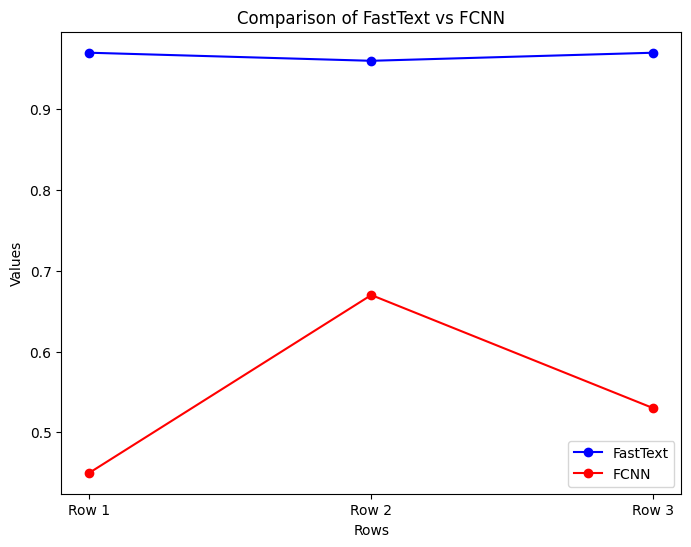

In [2]:
import matplotlib.pyplot as plt

# Values for FastText and FCNN from the image
fasttext = [0.97, 0.96, 0.97]
fcnn = [0.45, 0.67, 0.53]

# Labels for the x-axis
labels = ['Row 1', 'Row 2', 'Row 3']

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot FastText and FCNN
plt.plot(labels, fasttext, marker='o', label='FastText', color='blue')
plt.plot(labels, fcnn, marker='o', label='FCNN', color='red')

# Adding titles and labels
plt.title('Comparison of FastText vs FCNN')
plt.xlabel('Rows')
plt.ylabel('Values')

# Show legend
plt.legend()

# Show the plot
plt.show()
